In [89]:
#no log2 tranformation code

import pandas as pd
import numpy as np

# Load dataset with proper handling of mixed data types
file_path = "/content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv"
df = pd.read_csv(file_path, low_memory=False)  # Prevents DtypeWarning

# Ensure dataset has enough columns
if df.shape[1] < 2:
    raise ValueError("The dataset must contain at least two columns: Gene_ID and Gene_Name.")

# Rename columns for clarity
df.rename(columns={df.columns[0]: "Gene_ID", df.columns[1]: "Gene_Name"}, inplace=True)

# Identify expression columns
expression_cols = df.columns[2:]

# Convert expression columns to numeric, coercing errors to NaN
df[expression_cols] = df[expression_cols].apply(pd.to_numeric, errors='coerce')

# Fill missing values with 0 (assuming missing values imply no expression)
df.fillna(0, inplace=True)

# Drop duplicate genes, keeping the one with the highest total expression
df["Total_Expression"] = df[expression_cols].sum(axis=1)  # Compute total expression for sorting
df = df.sort_values(by=["Gene_ID", "Total_Expression"], ascending=[True, False])  # Sort by Gene_ID, then by expression
df = df.drop_duplicates(subset="Gene_ID", keep="first")  # Keep only the highest expression per Gene_ID
df.drop(columns=["Total_Expression"], inplace=True)  # Remove the temporary column

# Save the preprocessed data
output_path = "/content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv"
df.to_csv(output_path, index=False)

print(f"Preprocessed data saved at: {output_path}")


Preprocessed data saved at: /content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv


In [ ]:
%pip install pydeseq2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.4 MB/s eta 0:00:00


In [ ]:
#this imports the DeseqDataSet class from the pydeseq2.dds module.
#pydeseq2 is a Python implementation of the DESeq2 method, commonly used for differential gene expression analysis from RNA-seq count data.
#DeseqDataSet is used to create a dataset suitable for DESeq2 analysis.

from pydeseq2.dds import DeseqDataSet
import pandas as pd

In [90]:
#reads and display the csv file

counts=pd.read_csv("/content/GSE228582_Fibroblast_RNA_Seq_raw_counts.csv")
counts

,Gene_ID,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
0,0,32135.564190,32927.997990,27333.100400,43807.978780,35953.015470,37913.887250,21032.575670,20301.863380,32058.655320,23926.929520,33208.699430,40771.559390,29585.858930,28708.389690,24988.094880,24941.775790
1,42796,20.505090,19.419049,19.705419,20.650942,19.893176,19.994607,12.095198,22.277871,13.530673,24.618104,13.434793,16.575087,20.157209,22.222092,21.225607,13.129636
2,42797,6.912624,3.553181,9.216195,2.348778,6.215213,6.517229,5.800614,14.962573,2.972055,7.859744,1.369682,6.343552,5.202899,1.451953,6.952915,4.397386
3,42798,51.940829,129.149021,52.777637,107.881090,103.792926,97.391452,75.153944,68.303788,68.580734,70.517332,85.575342,59.206484,50.655850,95.478796,87.365647,116.311904
4,42799,29.968198,31.849817,30.844418,26.934685,27.322209,29.485718,31.642280,32.225255,33.664671,34.702503,32.169659,32.263441,33.180547,32.457848,33.087490,32.167609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10664,ZXDC,20.039525,20.503252,25.354483,17.854778,22.590556,20.184429,22.652034,20.084467,21.832316,22.613817,23.463246,23.310848,20.564859,26.526464,20.841275,20.142529
10665,ZYG11B,24.249849,30.175206,28.775747,23.772478,22.972684,22.373712,28.791370,26.866236,31.150715,31.103180,29.859065,27.164726,32.998177,29.440668,28.021295,24.602437
10666,ZYX,439.270433,590.257507,399.863531,401.763007,490.799490,517.505981,504.879255,417.280301,605.092579,511.680897,649.610340,364.975913,417.841029,677.804713,557.351250,617.374247
10667,ZZEF1,32.660377,34.919937,32.488746,24.423221,31.772886,28.435368,31.204764,33.932554,42.636703,45.857253,42.841267,30.796921,34.264037,34.949853,36.354311,23.935535


In [91]:
#This sets the "Gene_ID" column as the index of the counts DataFrame.
#After this operation, each row will be identified by its corresponding gene ID rather than a default numeric index.
#This is useful because gene expression data is typically structured with genes as row indices and samples as column names.

counts=counts.set_index("Gene_ID")
counts

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
0,32135.564190,32927.997990,27333.100400,43807.978780,35953.015470,37913.887250,21032.575670,20301.863380,32058.655320,23926.929520,33208.699430,40771.559390,29585.858930,28708.389690,24988.094880,24941.775790
42796,20.505090,19.419049,19.705419,20.650942,19.893176,19.994607,12.095198,22.277871,13.530673,24.618104,13.434793,16.575087,20.157209,22.222092,21.225607,13.129636
42797,6.912624,3.553181,9.216195,2.348778,6.215213,6.517229,5.800614,14.962573,2.972055,7.859744,1.369682,6.343552,5.202899,1.451953,6.952915,4.397386
42798,51.940829,129.149021,52.777637,107.881090,103.792926,97.391452,75.153944,68.303788,68.580734,70.517332,85.575342,59.206484,50.655850,95.478796,87.365647,116.311904
42799,29.968198,31.849817,30.844418,26.934685,27.322209,29.485718,31.642280,32.225255,33.664671,34.702503,32.169659,32.263441,33.180547,32.457848,33.087490,32.167609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZXDC,20.039525,20.503252,25.354483,17.854778,22.590556,20.184429,22.652034,20.084467,21.832316,22.613817,23.463246,23.310848,20.564859,26.526464,20.841275,20.142529
ZYG11B,24.249849,30.175206,28.775747,23.772478,22.972684,22.373712,28.791370,26.866236,31.150715,31.103180,29.859065,27.164726,32.998177,29.440668,28.021295,24.602437
ZYX,439.270433,590.257507,399.863531,401.763007,490.799490,517.505981,504.879255,417.280301,605.092579,511.680897,649.610340,364.975913,417.841029,677.804713,557.351250,617.374247


In [92]:
#This transposes the counts DataFrame, meaning rows become columns and columns become rows.
#Some bioinformatics tools (including DESeq2) expect samples as rows and genes as columns for analysis.
#Transposing makes it easier to align metadata with sample information.
#It ensures that each sample is treated as an observation, with gene expression values as features.

counts=counts.T
counts

Gene_ID,0,42796,42797,42798,42799,42800,42801,42802,42980,42983,...,ZUFSP,ZW10,ZWILCH,ZWINT,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
Gene_Name,32135.56419,20.505090,6.912624,51.940829,29.968198,85.714513,56.859621,19.604323,569.648796,15.242184,...,5.819559,13.845490,16.446580,12.620852,6.092825,20.039525,24.249849,439.270433,32.660377,39.188404
2525-normal breast fibroblast,32927.99799,19.419049,3.553181,129.149021,31.849817,79.994889,56.593271,16.080561,624.125445,85.652069,...,7.363995,14.502562,22.929292,26.353657,5.259997,20.503252,30.175206,590.257507,34.919937,36.347651
8727-normal adjacent breast fibroblast,27333.10040,19.705419,9.216195,52.777637,30.844418,87.202447,47.552916,19.904330,488.378789,27.277286,...,6.007103,12.465070,10.701395,7.744256,5.755149,25.354483,28.775747,399.863531,32.488746,33.828078
4009- normal breast fibroblast,43807.97878,20.650942,2.348778,107.881090,26.934685,83.020650,52.832247,21.016985,554.230202,61.007214,...,5.622832,11.062641,11.845567,9.079907,6.548108,17.854778,23.772478,401.763007,24.423221,30.035885
30413-DCIS fibroblast,35953.01547,19.893176,6.215213,103.792926,27.322209,82.618495,54.891679,19.106440,504.994452,40.730435,...,5.675737,13.104770,16.173040,19.083962,5.922996,22.590556,22.972684,490.799490,31.772886,36.380910
70213-DCIS fibroblast,37913.88725,19.994607,6.517229,97.391452,29.485718,80.737716,58.882851,19.007531,525.111524,31.156153,...,6.732361,18.476029,23.069727,28.232891,5.315022,20.184429,22.373712,517.505981,28.435368,38.521255
80H- DCIS fibroblast,21032.57567,12.095198,5.800614,75.153944,31.642280,81.377961,57.272245,18.545030,605.860751,30.569661,...,7.480111,20.746723,37.033605,55.620975,6.717986,22.652034,28.791370,504.879255,31.204764,44.951232
21714-DCIS fibroblast,20301.86338,22.277871,14.962573,68.303788,32.225255,87.250056,74.445319,14.927004,517.975332,9.852534,...,9.105591,22.313440,50.993680,81.274512,6.094106,20.084467,26.866236,417.280301,33.932554,40.002947
1213249-DCIS fibroblast,32058.65532,13.530673,2.972055,68.580734,33.664671,87.485687,69.977377,16.927307,559.874881,45.105967,...,7.407792,21.843489,34.916063,65.228792,6.435729,21.832316,31.150715,605.092579,42.636703,44.312674
102115- DCIS fibroblast,23926.92952,24.618104,7.859744,70.517332,34.702503,75.239475,63.087827,22.876158,631.812209,15.257768,...,7.712833,23.044057,43.391245,56.298435,5.960394,22.613817,31.103180,511.680897,45.857253,43.978890


In [93]:
import pandas as pd

# Assuming 'counts' is your DataFrame where sample names are the index
# You can extract the sample names like this (skip the first two rows if needed)
sample_names = [
    "2525-normal breast fibroblast",
    "8727-normal adjacent breast fibroblast",
    "4009- normal breast fibroblast",
    "30413-DCIS fibroblast",
    "70213-DCIS fibroblast",
    "80H- DCIS fibroblast",
    "21714-DCIS fibroblast",
    "1213249-DCIS fibroblast",
    "102115- DCIS fibroblast",
    "2760- IDC fibroblast",
    "8727- IDC fibroblast",
    "2300- IDC fibroblast",
    "8870- IDC fibroblast",
    "9019- IDC fibroblast",
    "8661- IDC fibroblast"
]

# Define conditions based on sample names
conditions = []
for name in sample_names:
    name_lower = name.lower()
    if "normal" in name_lower:
        conditions.append("Normal")
    elif "dcis" in name_lower:
        conditions.append("DCIS")
    elif "idc" in name_lower:
        conditions.append("IDC")
    else:
        conditions.append("Unknown")

# Create metadata DataFrame
metadata = pd.DataFrame(zip(sample_names, conditions), columns=["Sample", "Condition"])
print(metadata)

                                    Sample Condition
0            2525-normal breast fibroblast    Normal
1   8727-normal adjacent breast fibroblast    Normal
2           4009- normal breast fibroblast    Normal
3                    30413-DCIS fibroblast      DCIS
4                    70213-DCIS fibroblast      DCIS
5                     80H- DCIS fibroblast      DCIS
6                    21714-DCIS fibroblast      DCIS
7                  1213249-DCIS fibroblast      DCIS
8                  102115- DCIS fibroblast      DCIS
9                     2760- IDC fibroblast       IDC
10                    8727- IDC fibroblast       IDC
11                    2300- IDC fibroblast       IDC
12                    8870- IDC fibroblast       IDC
13                    9019- IDC fibroblast       IDC
14                    8661- IDC fibroblast       IDC


In [94]:
#shows datatype of counts

counts.dtypes

,0
Gene_ID,
0,float64
42796,float64
42797,float64
42798,float64
42799,float64
...,...
ZXDC,float64
ZYG11B,float64
ZYX,float64


In [95]:
# Recreate metadata, ensuring it matches the length of the counts DataFrame
metadata = pd.DataFrame({'Condition': ['normal'] * 4 + ['DCIS'] * 6 + ['IDC'] * 6}, index=counts.index)
#3 normal samples, 6 DCIS, 6 IDC for a total of 15

print(metadata.head())
print(metadata['Condition'].value_counts())

                                       Condition
Gene_Name                                 normal
2525-normal breast fibroblast             normal
8727-normal adjacent breast fibroblast    normal
4009- normal breast fibroblast            normal
30413-DCIS fibroblast                       DCIS
Condition
DCIS      6
IDC       6
normal    4
Name: count, dtype: int64


In [96]:
pip install pydeseq2

In [97]:
from pydeseq2.dds import DeseqDataSet

In [100]:
# Convert float count values to integers
raw_counts = counts.astype(int)

# Now use raw_counts in DESeq2
dds = DeseqDataSet(counts=raw_counts,
                   metadata=metadata,
                   design="~ Condition")


In [101]:
#This performs DESeq2 normalization and statistical testing on the dataset (dds).
#The method applies size factor normalization, dispersion estimation, and Wald significance testing to identify differentially expressed genes (DEGs).
dds.deseq2()


Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.02 seconds.

Fitting dispersions...
... done in 10.31 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 26.27 seconds.

Fitting LFCs...
... done in 8.17 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [102]:
dds

AnnData object with n_obs × n_vars = 16 × 10669
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [103]:
# Imports the DeseqStats class from the pydeseq2.ds module.
#DeseqStats is used to compute statistical results after running deseq2() on a DeseqDataSet (dds).
#It helps extract log fold changes (LFC), p-values, and adjusted p-values for differential expression analysis.

from pydeseq2.ds import DeseqStats

In [104]:
#The contrast argument specifies which groups to compare in differential expression analysis.
#contrast = ('Condition', 'Group1', 'Group2')
#'Condition' → The column name in metadata that defines the experimental groups.
#'Group1' → The reference group (e.g., Control).
#'Group2' → The comparison group (e.g., iDC vs DCIS).



In [167]:
# Convert float counts to integers as required by DESeq2
# The DESeq2 algorithm expects raw integer counts for each gene per sample
raw_counts = counts.astype(int)

# This initializes a DESeq2 dataset (dds) using the pydeseq2 package. The dataset will be used for differential expression analysis.
# counts=raw_counts: Provides the gene expression count matrix (integer values), where rows = samples, columns = genes.
# metadata=metadata: Sample metadata indexed by sample names. It contains the "Condition" column (e.g., Control, Dilated, Ischemic or IDC, DCIS).
# design="~ Condition": The statistical model that will compare gene expression differences based on the "Condition" variable.
dds = DeseqDataSet(counts=raw_counts,
                   metadata=metadata,
                   design="~ Condition")

# This performs DESeq2 normalization and statistical testing on the dataset (dds).
# It applies size factor normalization, dispersion estimation, and Wald tests to identify differentially expressed genes (DEGs).
dds.deseq2()

# This creates a DeseqStats object for statistical analysis between specific conditions.
# dds → The DeseqDataSet object. Contrast specifies the groups to compare: 'IDC' vs 'DCIS' in this example.
stat_res_cd = DeseqStats(dds, contrast=('Condition', 'normal', 'DCIS'))

# Summarizes the statistical results including the number of significantly up/downregulated genes
stat_res_cd.summary()


Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 11.77 seconds.

Fitting dispersion trend curve...
... done in 0.28 seconds.

Fitting MAP dispersions...
... done in 21.49 seconds.

Fitting LFCs...
... done in 6.12 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.

Running Wald tests...
... done in 4.64 seconds.



Log2 fold change & Wald test p-value: Condition normal vs DCIS
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene_ID                                                                      
0        31001.243281        0.440094  0.253309  1.737382  0.082320  0.562717
42796       18.290451        0.306505  0.266653  1.149452  0.250370  0.807810
42797        5.162217       -0.200521  0.606805 -0.330454  0.741057  0.975469
42798       82.867333        0.260071  0.325362  0.799327  0.424101  0.910443
42799       30.977835        0.109663  0.193243  0.567488  0.570383  0.953721
...               ...             ...       ...       ...       ...       ...
ZXDC        21.389965        0.158955  0.237291  0.669872  0.502940  0.935988
ZYG11B      27.055111        0.184750  0.207122  0.891984  0.372401  0.886000
ZYX        508.913536        0.043835  0.182973  0.239573  0.810661  0.984427
ZZEF1       32.894893        0.008454  0.196787  0.042959  0.965734  0.998566
Z

In [168]:
#stat_res_cd → The DeseqStats object you created for Control vs. Dilated.
#.results_df → Extracts the results as a Pandas DataFrame.
#results_cd → Stores this DataFrame in a variable for further analysis.

results_cd = stat_res_cd.results_df
results_cd.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,31001.243281,0.440094,0.253309,1.737382,0.082320,0.562717
42796,18.290451,0.306505,0.266653,1.149452,0.250370,0.807810
42797,5.162217,-0.200521,0.606805,-0.330454,0.741057,0.975469
42798,82.867333,0.260071,0.325362,0.799327,0.424101,0.910443
42799,30.977835,0.109663,0.193243,0.567488,0.570383,0.953721


In [169]:
stat_res_ci = DeseqStats(dds, contrast=('Condition', 'normal', 'IDC'))
stat_res_ci.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: Condition normal vs IDC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene_ID                                                                      
0        31001.243281        0.251854  0.253307  0.994262  0.320095  0.999766
42796       18.290451        0.248559  0.268077  0.927194  0.353826  0.999766
42797        5.162217        0.473575  0.637285  0.743114  0.457413  0.999766
42798       82.867333        0.123643  0.325260  0.380135  0.703845  0.999766
42799       30.977835       -0.067331  0.192013 -0.350658  0.725845  0.999766
...               ...             ...       ...       ...       ...       ...
ZXDC        21.389965       -0.011667  0.235972 -0.049441  0.960568  0.999766
ZYG11B      27.055111       -0.010382  0.205407 -0.050545  0.959688  0.999766
ZYX        508.913536       -0.176317  0.182840 -0.964325  0.334883  0.999766
ZZEF1       32.894893       -0.028272  0.198179 -0.142660  0.886559  0.999766
ZZ

... done in 4.20 seconds.



In [170]:
stat_res_di = DeseqStats(dds, contrast=('Condition', 'DCIS', 'IDC'))
stat_res_di.summary()


Running Wald tests...


Log2 fold change & Wald test p-value: Condition DCIS vs IDC
             baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
Gene_ID                                                                      
0        31001.243281       -0.188240  0.226570 -0.830825  0.406072  0.999228
42796       18.290451       -0.057946  0.243334 -0.238132  0.811778  0.999228
42797        5.162217        0.674096  0.558801  1.206326  0.227692  0.908867
42798       82.867333       -0.136428  0.291245 -0.468433  0.639475  0.999228
42799       30.977835       -0.176994  0.168777 -1.048682  0.294325  0.964007
...               ...             ...       ...       ...       ...       ...
ZXDC        21.389965       -0.170621  0.209262 -0.815347  0.414874  0.999228
ZYG11B      27.055111       -0.195132  0.182744 -1.067790  0.285615  0.959111
ZYX        508.913536       -0.220152  0.163216 -1.348842  0.177388  0.852116
ZZEF1       32.894893       -0.036726  0.172616 -0.212762  0.831513  0.999228
ZZZ3

... done in 4.58 seconds.



In [171]:
results_ci = stat_res_ci.results_df
results_ci.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,31001.243281,0.251854,0.253307,0.994262,0.320095,0.999766
42796,18.290451,0.248559,0.268077,0.927194,0.353826,0.999766
42797,5.162217,0.473575,0.637285,0.743114,0.457413,0.999766
42798,82.867333,0.123643,0.325260,0.380135,0.703845,0.999766
42799,30.977835,-0.067331,0.192013,-0.350658,0.725845,0.999766


In [172]:
results_di = stat_res_di.results_df
results_di.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,31001.243281,-0.188240,0.226570,-0.830825,0.406072,0.999228
42796,18.290451,-0.057946,0.243334,-0.238132,0.811778,0.999228
42797,5.162217,0.674096,0.558801,1.206326,0.227692,0.908867
42798,82.867333,-0.136428,0.291245,-0.468433,0.639475,0.999228
42799,30.977835,-0.176994,0.168777,-1.048682,0.294325,0.964007


In [173]:
#filters the differentially expressed gene results to remove low-expression genes by keeping only genes where baseMean is greater than or equal to 10.

results_cd = results_cd[results_cd.baseMean>=10]
results_cd

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,31001.243281,0.440094,0.253309,1.737382,0.082320,0.562717
42796,18.290451,0.306505,0.266653,1.149452,0.250370,0.807810
42798,82.867333,0.260071,0.325362,0.799327,0.424101,0.910443
42799,30.977835,0.109663,0.193243,0.567488,0.570383,0.953721
42800,80.015029,0.231312,0.145135,1.593769,0.110988,0.634468
...,...,...,...,...,...,...
ZXDC,21.389965,0.158955,0.237291,0.669872,0.502940,0.935988
ZYG11B,27.055111,0.184750,0.207122,0.891984,0.372401,0.886000
ZYX,508.913536,0.043835,0.182973,0.239573,0.810661,0.984427


In [174]:
##DESeq2, "baseMean" refers to the average of the normalized count values, divided by size factors, taken over all samples.
results_ci= results_ci[results_ci.baseMean>=10]
results_ci

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,31001.243281,0.251854,0.253307,0.994262,0.320095,0.999766
42796,18.290451,0.248559,0.268077,0.927194,0.353826,0.999766
42798,82.867333,0.123643,0.325260,0.380135,0.703845,0.999766
42799,30.977835,-0.067331,0.192013,-0.350658,0.725845,0.999766
42800,80.015029,0.242899,0.146456,1.658510,0.097215,0.973858
...,...,...,...,...,...,...
ZXDC,21.389965,-0.011667,0.235972,-0.049441,0.960568,0.999766
ZYG11B,27.055111,-0.010382,0.205407,-0.050545,0.959688,0.999766
ZYX,508.913536,-0.176317,0.182840,-0.964325,0.334883,0.999766


In [175]:
##DESeq2, "baseMean" refers to the average of the normalized count values, divided by size factors, taken over all samples.
results_di= results_di[results_di.baseMean>=10]
results_di

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
0,31001.243281,-0.188240,0.226570,-0.830825,0.406072,0.999228
42796,18.290451,-0.057946,0.243334,-0.238132,0.811778,0.999228
42798,82.867333,-0.136428,0.291245,-0.468433,0.639475,0.999228
42799,30.977835,-0.176994,0.168777,-1.048682,0.294325,0.964007
42800,80.015029,0.011587,0.131654,0.088008,0.929870,0.999228
...,...,...,...,...,...,...
ZXDC,21.389965,-0.170621,0.209262,-0.815347,0.414874,0.999228
ZYG11B,27.055111,-0.195132,0.182744,-1.067790,0.285615,0.959111
ZYX,508.913536,-0.220152,0.163216,-1.348842,0.177388,0.852116


In [176]:
#differentially expressed genes that are significant
# "padj" refers to the adjusted p-value, which is a p-value corrected for multiple testing using methods like the
#Benjamini-Hochberg procedure (FDR control).
#This filters the differentially expressed genes (DEGs) based on statistical significance and biological relevance.
#results_cd.padj < 0.05 → Selects genes with statistically significant differential expression (adjusted p-value < 0.05).
#abs(results_cd.log2FoldChange) > 0.5 → Keeps genes with a biologically meaningful expression change:

sigs_cd=results_cd[(results_cd.padj<0.05) & (abs(results_cd.log2FoldChange) > 0.5)]
sigs_cd

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
AURKB,13.202862,-2.257361,0.568234,-3.972587,7.109631e-05,0.040552
BRCA1,10.005438,-1.892177,0.514728,-3.676069,2.368556e-04,0.049399
CBX3,89.371055,-0.585985,0.157647,-3.717067,2.015490e-04,0.046615
CDC25B,48.457178,-0.851808,0.226232,-3.765197,1.664176e-04,0.044787
CDCA5,12.903311,-2.182391,0.536797,-4.065581,4.791294e-05,0.038067
CDKN1A,495.591125,0.903651,0.196108,4.607923,4.067108e-06,0.013617
CLSPN,11.681258,-2.334911,0.609503,-3.830845,1.277038e-04,0.044787
DEK,125.363591,-0.816713,0.208059,-3.925384,8.659167e-05,0.040552
DNAJC9,42.305630,-1.061751,0.290347,-3.656841,2.553430e-04,0.049399


In [177]:
sigs_ci=results_ci[(results_ci.padj<0.05) & (abs(results_ci.log2FoldChange) > 0.5)]
sigs_ci

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,


In [178]:
sigs_di=results_di[(results_di.padj<0.05) & (abs(results_di.log2FoldChange) > 0.5)]
sigs_di

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
ADAMTS2,257.705560,-1.006219,0.240398,-4.185634,2.843707e-05,0.021013
ADAMTS7,60.910168,-2.087677,0.557465,-3.744948,1.804313e-04,0.039271
CAMK2N1,14.187369,2.436800,0.658145,3.702526,2.134634e-04,0.041702
CCDC144A,14.497375,-2.964808,0.627033,-4.728310,2.263965e-06,0.003712
CELF2,12.930385,2.628147,0.699910,3.754978,1.733566e-04,0.039271
COBLL1,57.860660,-1.694049,0.388134,-4.364600,1.273555e-05,0.012348
DSTN,596.111655,-1.142740,0.296809,-3.850084,1.180772e-04,0.035692
ESM1,28.216611,2.452853,0.613977,3.995022,6.468819e-05,0.026562
ETV1,13.840525,2.044557,0.552485,3.700658,2.150410e-04,0.041702


In [179]:
# Check how many are statistically significant
sum(results_ci.padj < 0.05)

# Check how many have large enough fold change
sum(abs(results_ci.log2FoldChange) > 0.5)


960

In [180]:
# Check how many are statistically significant
sum(results_di.padj < 0.05)

# Check how many have large enough fold change
sum(abs(results_di.log2FoldChange) > 0.5)


976

In [181]:
sum((results_ci.padj < 0.05) & (abs(results_ci.log2FoldChange) > 0.5))
sum((results_di.padj < 0.05) & (abs(results_di.log2FoldChange) > 0.5))


50

In [182]:
len(results_ci)


8573

In [183]:
results_ci.padj.notna().sum()


np.int64(8571)

In [184]:
results_ci.padj.isna().sum()
results_di.padj.isna().sum()


np.int64(2)

In [127]:
results_ci.log2FoldChange.describe()
results_ci.log2FoldChange.isna().sum()


np.int64(0)

In [185]:
(results_ci.padj < 0.1) & (abs(results_ci.log2FoldChange) > 0.2)


,0
Gene_ID,
0,False
42796,False
42798,False
42799,False
42800,False
...,...
ZXDC,False
ZYG11B,False
ZYX,False


In [186]:
results_ci.sort_values("padj").head(10)


,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene_ID,,,,,,
PLD5,11.164231,6.705753,1.697654,3.950013,0.000078,0.176293
LOC101928174,47.162895,4.226943,1.073759,3.936583,0.000083,0.176293
CTSC,71.334437,-2.229324,0.526828,-4.231596,0.000023,0.176293
ERGIC3,202.891823,0.501384,0.125647,3.990409,0.000066,0.176293
SFRP1,47.371706,4.775909,1.180943,4.044147,0.000053,0.176293
TNFRSF21,36.098278,2.646327,0.681418,3.883561,0.000103,0.182972
ACTC1,24.749799,4.395593,1.160715,3.786969,0.000152,0.232339
MAN1B1,108.298932,0.583085,0.156861,3.717213,0.000201,0.268535
ATP13A1,54.783674,0.553942,0.150734,3.674963,0.000238,0.281893


In [188]:
dds


AnnData object with n_obs × n_vars = 16 × 10669
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [189]:
import numpy as np
import seaborn as sns

In [190]:
#dds.layers['normed_counts'] → Extracts normalized counts (expression values adjusted for sequencing depth and library size).

dds.layers['normed_counts']

array([[3.24447166e+04, 2.01927597e+01, 6.05782790e+00, ...,
        4.43231075e+02, 3.23084155e+01, 3.93758813e+01],
       [3.36424663e+04, 1.94128484e+01, 3.06518659e+00, ...,
        6.02820030e+02, 3.47387814e+01, 3.67822391e+01],
       [3.14402177e+04, 2.18550520e+01, 1.03523931e+01, ...,
        4.58956092e+02, 3.68085086e+01, 3.79587745e+01],
       ...,
       [2.95028342e+04, 2.26091108e+01, 1.02768686e+00, ...,
        6.95744001e+02, 3.49413531e+01, 3.90521005e+01],
       [2.38745127e+04, 2.00642215e+01, 5.73263471e+00, ...,
        5.32179589e+02, 3.43958083e+01, 4.01284430e+01],
       [2.78289038e+04, 1.45052624e+01, 4.46315767e+00, ...,
        6.88442070e+02, 2.56631566e+01, 4.01684190e+01]])

In [191]:
#This applies a log transformation to the normalized counts to make gene expression values more comparable and easier to analyze.

dds.layers['log1p']= np.log1p(dds.layers['normed_counts'])
dds

AnnData object with n_obs × n_vars = 16 × 10669
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [192]:
dds.layers['log1p']

array([[10.38732371,  3.0536596 ,  1.95413734, ...,  6.09634487,
         3.50581008,  3.69823261],
       [10.42357415,  3.01616453,  1.40245964, ...,  6.40327619,
         3.57623641,  3.63183913],
       [10.35587498,  3.12917219,  2.42942856, ...,  6.13113103,
         3.63253417,  3.66250402],
       ...,
       [10.29227551,  3.16163269,  0.70689566, ...,  6.54641806,
         3.58188853,  3.69018112],
       [10.08060864,  3.04757594,  1.90696656, ...,  6.27885831,
         3.5665934 ,  3.71669993],
       [10.2338664 ,  2.74117948,  1.69802695, ...,  6.53588268,
         3.28328271,  3.71767143]])

In [193]:
#This subsets the DESeq2 dataset (dds), keeping only the significantly differentially expressed genes (DEGs) identified in sigs_cd.
#sigs_cd.index → Extracts the gene names (index) from the sigs_cd DataFrame, which contains significant DEGs.
#dds[:, sigs_cd.index] → Selects only those genes from dds while keeping all samples.
#Rows (:) → Keeps all samples.
#Columns (sigs_cd.index) → Selects only significant DEGs.
#dds_sigs_cd → Stores the subsetted dataset with only differentially expressed genes.

dds_sigs_cd = dds[:, sigs_cd.index]
dds_sigs_cd

View of AnnData object with n_obs × n_vars = 16 × 48
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [194]:
dds_sigs_ci = dds[:, sigs_ci.index]
dds_sigs_ci

View of AnnData object with n_obs × n_vars = 16 × 0
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [195]:
dds_sigs_di = dds[:, sigs_di.index]
dds_sigs_di

View of AnnData object with n_obs × n_vars = 16 × 50
    obs: 'Condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'log1p'

In [196]:
#This creates a DataFrame for visualization by extracting and reformatting the log-transformed normalized counts.
#dds_sigs_cd.layers['log1p'] → Retrieves the log-transformed gene expression values for the significant DEGs.
#.T → Transposes the matrix to have: Genes as rows (index = dds_sigs_cd.var_names). Samples as columns (columns = dds_sigs_cd.obs_names).
#pd.DataFrame(...) → Converts this into a Pandas DataFrame named grapher_cd.


grapher_cd = pd.DataFrame(dds_sigs_cd.layers['log1p'].T, index= dds_sigs_cd.var_names, columns = dds_sigs_cd.obs_names)
grapher_cd

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
AURKB,1.799759,2.216355,1.194084,1.186760,2.348298,2.915160,3.267262,3.482109,3.079269,3.244887,2.939525,1.464717,3.124020,1.814570,2.356542,2.040537
BRCA1,1.799759,1.809705,1.722957,1.186760,2.123913,2.421767,2.931783,3.168441,2.996430,2.923884,2.430726,1.692877,2.891040,1.814570,1.906967,1.883875
CBX3,4.340200,4.351950,4.281052,4.097468,4.380749,4.525750,4.642727,4.817130,4.845631,4.741506,4.546525,4.335938,4.598063,4.370766,4.373818,4.490291
CDC25B,3.672909,3.684512,3.312589,3.457328,3.712960,4.136677,4.108029,4.311683,4.030931,4.317174,3.967186,3.684045,4.178497,3.581889,3.739665,3.844758
CDCA5,1.799759,2.216355,1.194084,1.186760,2.242386,2.857917,3.267262,3.454816,3.079269,3.097211,2.939525,1.464717,2.990834,2.221537,2.156809,2.401716
CDKN1A,6.610809,6.335006,6.476588,6.638058,6.123596,5.968959,5.870289,5.728555,5.799962,5.844537,5.949708,6.483211,6.016728,6.006128,6.594353,6.120575
CLSPN,1.617119,1.964364,1.194084,0.759976,1.989493,2.220572,3.026777,3.204622,3.260549,3.097211,3.121339,1.464717,2.780173,2.327198,2.156809,2.585783
DEK,4.542089,4.616401,4.400831,4.286454,4.655342,4.923874,5.014406,5.099231,5.064475,5.311598,5.028718,4.458705,5.102939,4.863379,4.699753,4.713694
DNAJC9,3.228086,3.576236,3.077533,3.013072,3.381104,3.763281,4.076810,4.238606,4.030931,4.079643,3.930859,3.501176,4.149109,3.690181,3.452336,3.999262


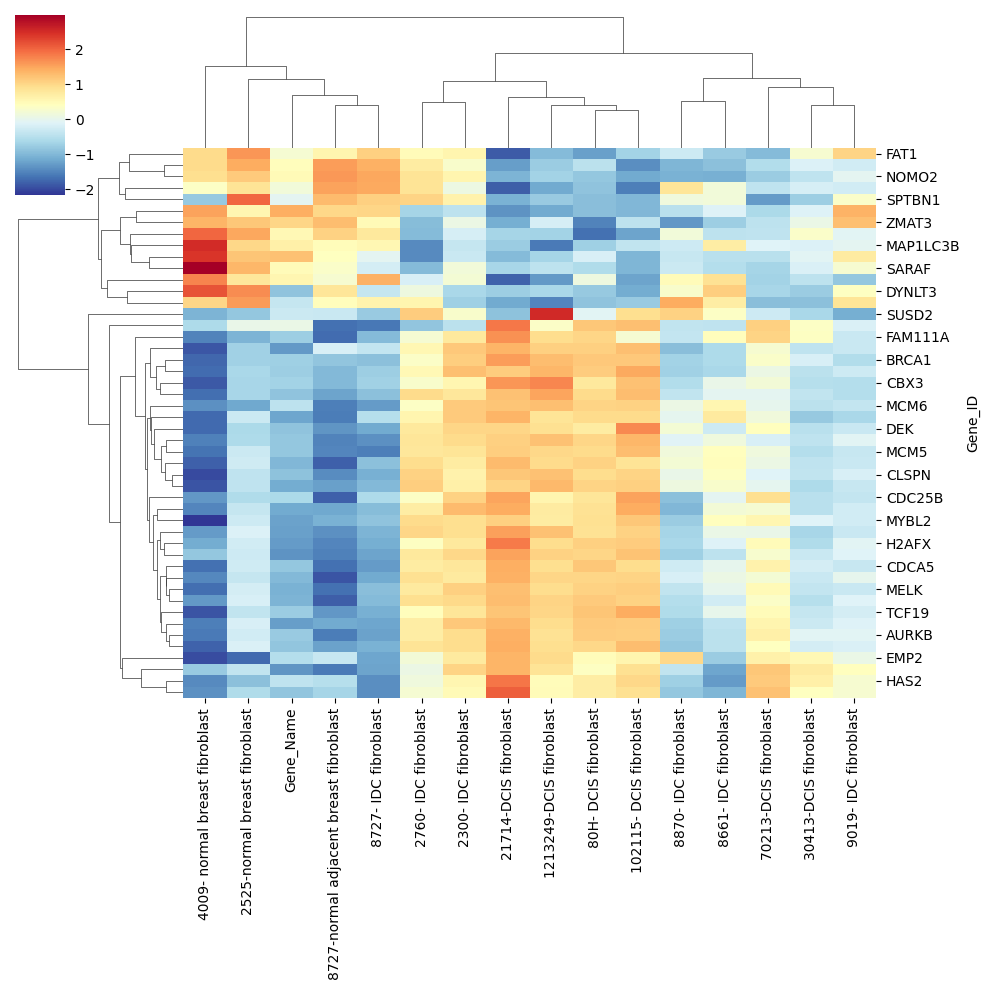

In [197]:
#This creates a hierarchical clustering heatmap of the log-transformed gene expression values for significant differentially expressed genes (DEGs).
#sns.clustermap(...) → Uses Seaborn’s clustermap function to generate a heatmap with hierarchical clustering.
#z_score=0 → Standardizes gene expression values row-wise (per gene):
#Each gene's expression is normalized to a mean of 0 and standard deviation of 1.
#Helps compare genes with different absolute expression levels.

g_cd =sns.clustermap(grapher_cd, z_score=0, cmap='RdYlBu_r')
g_cd

# Save the heatmap as an image file
g_cd.savefig("heatmap_cd.png", dpi=300)  # Save as PNG with high resolution

In [198]:
grapher_ci = pd.DataFrame(dds_sigs_ci.layers['log1p'].T, index= dds_sigs_ci.var_names, columns = dds_sigs_ci.obs_names)
grapher_ci

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,


In [199]:
grapher_di = pd.DataFrame(dds_sigs_di.layers['log1p'].T, index= dds_sigs_di.var_names, columns = dds_sigs_di.obs_names)
grapher_di

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
ADAMTS2,5.356654,5.715157,5.652895,5.252711,5.276147,5.185134,5.326514,4.225890,5.266478,5.328830,5.988261,5.908094,5.763805,5.807971,5.463993,6.098263
ADAMTS7,3.592846,4.636406,3.502774,3.343476,3.416256,3.116093,3.518024,1.012171,3.749151,3.097211,5.082765,4.458705,3.682601,5.268915,3.511095,4.790732
CAMK2N1,2.311222,1.402460,2.429429,3.492569,3.450215,3.491154,1.888395,3.720525,2.504343,3.311278,1.059501,0.000000,2.030224,2.422754,1.906967,1.172971
CCDC144A,2.781584,3.156065,2.904384,2.419837,1.834157,1.406029,1.555862,0.000000,1.671728,1.292537,2.939525,4.179128,2.942181,1.116902,3.091936,3.240534
CELF2,3.144671,1.626672,3.077533,2.057879,3.139460,3.392631,1.336152,3.559784,1.953013,3.660194,0.000000,1.692877,1.061335,1.814570,2.156809,1.172971
COBLL1,3.838026,4.817111,3.747374,4.134593,3.686951,3.392631,3.267262,2.765585,3.324762,3.056613,4.372288,3.993071,3.471617,4.996937,4.144777,4.862257
DSTN,5.980829,6.513704,6.205798,6.720977,6.121289,6.082951,5.827164,5.462603,6.102477,5.762183,6.696585,6.414811,6.009792,7.359662,6.403379,6.826031
ESM1,2.953528,3.239521,2.202970,3.013072,3.450215,3.875824,2.502870,5.224620,3.324762,3.136224,2.888391,1.168619,2.512956,2.221537,2.039670,2.666497
ETV1,2.647967,1.964364,2.202970,2.894440,2.242386,2.102428,3.071091,4.132040,3.469284,2.714082,1.895338,1.464717,2.433284,1.814570,2.156809,1.172971


In [201]:
# Extract the results into a DataFrame
results_di_df = stat_res_di.results_df

# Now filter based on adjusted p-value (padj)
sig_genes_di = results_di_df[results_di_df["padj"] < 0.05]

# Check how many genes passed the filter
print(f"Significant genes (padj < 0.05): {sig_genes_di.shape[0]}")


Significant genes (padj < 0.05): 59


In [202]:
print(dds_sigs_di.shape)


(16, 50)


In [204]:
grapher_di = pd.DataFrame(dds_sigs_di.layers['log1p'].T, index= dds_sigs_di.var_names, columns = dds_sigs_di.obs_names)
grapher_di

,Gene_Name,2525-normal breast fibroblast,8727-normal adjacent breast fibroblast,4009- normal breast fibroblast,30413-DCIS fibroblast,70213-DCIS fibroblast,80H- DCIS fibroblast,21714-DCIS fibroblast,1213249-DCIS fibroblast,102115- DCIS fibroblast,2760- IDC fibroblast,8727- IDC fibroblast,2300- IDC fibroblast,8870- IDC fibroblast,9019- IDC fibroblast,8661- IDC fibroblast
Gene_ID,,,,,,,,,,,,,,,,
ADAMTS2,5.356654,5.715157,5.652895,5.252711,5.276147,5.185134,5.326514,4.225890,5.266478,5.328830,5.988261,5.908094,5.763805,5.807971,5.463993,6.098263
ADAMTS7,3.592846,4.636406,3.502774,3.343476,3.416256,3.116093,3.518024,1.012171,3.749151,3.097211,5.082765,4.458705,3.682601,5.268915,3.511095,4.790732
CAMK2N1,2.311222,1.402460,2.429429,3.492569,3.450215,3.491154,1.888395,3.720525,2.504343,3.311278,1.059501,0.000000,2.030224,2.422754,1.906967,1.172971
CCDC144A,2.781584,3.156065,2.904384,2.419837,1.834157,1.406029,1.555862,0.000000,1.671728,1.292537,2.939525,4.179128,2.942181,1.116902,3.091936,3.240534
CELF2,3.144671,1.626672,3.077533,2.057879,3.139460,3.392631,1.336152,3.559784,1.953013,3.660194,0.000000,1.692877,1.061335,1.814570,2.156809,1.172971
COBLL1,3.838026,4.817111,3.747374,4.134593,3.686951,3.392631,3.267262,2.765585,3.324762,3.056613,4.372288,3.993071,3.471617,4.996937,4.144777,4.862257
DSTN,5.980829,6.513704,6.205798,6.720977,6.121289,6.082951,5.827164,5.462603,6.102477,5.762183,6.696585,6.414811,6.009792,7.359662,6.403379,6.826031
ESM1,2.953528,3.239521,2.202970,3.013072,3.450215,3.875824,2.502870,5.224620,3.324762,3.136224,2.888391,1.168619,2.512956,2.221537,2.039670,2.666497
ETV1,2.647967,1.964364,2.202970,2.894440,2.242386,2.102428,3.071091,4.132040,3.469284,2.714082,1.895338,1.464717,2.433284,1.814570,2.156809,1.172971


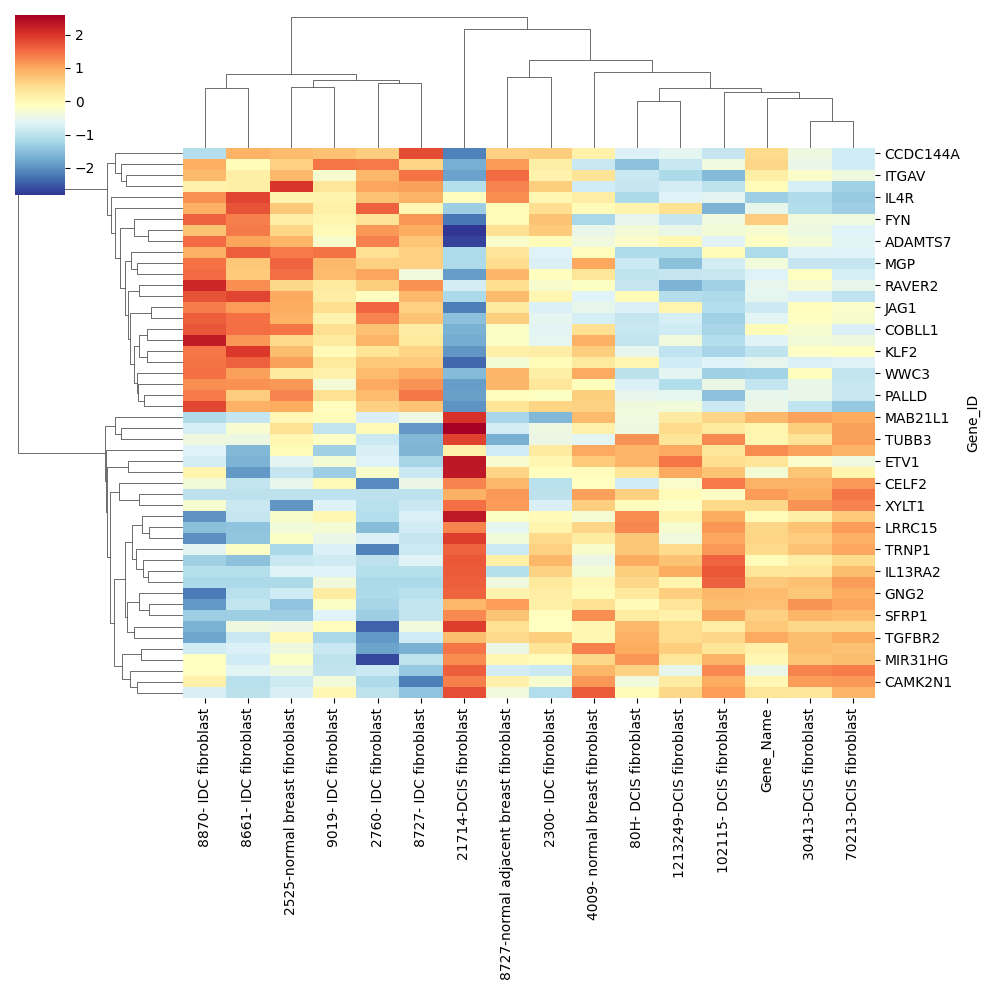

In [205]:
g_di= sns.clustermap(grapher_di, z_score=0, cmap='RdYlBu_r')
g_di
g_di.savefig("heatmap_di.png", dpi=300)  # Save as PNG with high resolution

## volacno plots

In [206]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_cd['-log10(padj)'] = -np.log10(results_cd['padj'])  # Convert p-value scale
results_cd['Significance'] = np.where(
    (results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_cd,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()

<ipython-input-206-fe43f887c017>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-206-fe43f887c017>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [207]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_ci['-log10(padj)'] = -np.log10(results_ci['padj'])  # Convert p-value scale
results_ci['Significance'] = np.where(
    (results_ci['padj'] < pval_threshold) & (results_ci['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_ci['padj'] < pval_threshold) & (results_ci['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_ci,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()

<ipython-input-207-d57f9748aa55>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-207-d57f9748aa55>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [208]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_di['-log10(padj)'] = -np.log10(results_di['padj'])  # Convert p-value scale
results_di['Significance'] = np.where(
    (results_di['padj'] < pval_threshold) & (results_di['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_di['padj'] < pval_threshold) & (results_di['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_di,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()


In [217]:
dds.deseq2()


Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 9.94 seconds.

Fitting dispersion trend curve...
... done in 0.26 seconds.

Fitting MAP dispersions...
... done in 20.75 seconds.

Fitting LFCs...
... done in 9.53 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [228]:
# List all variables in the current session
print(globals().keys())


dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'pd', 'np', 'file_path', '_i2', 'df', 'expression_cols', 'output_path', '_i3', '_exit_code', '_i4', 'DeseqDataSet', '_i5', 'counts', '_5', '_i6', '_6', '_i7', '_7', '_i8', 'sample_names', 'conditions', 'name', 'name_lower', 'metadata', '_i9', '_9', '_i10', '_i11', '_i12', '_i13', 'dds', '_i14', '_i15', '_15', '_i16', 'DeseqStats', '_i17', '_i18', 'stat_res_cd', '_i19', 'results_cd', '_19', '_i20', 'stat_res_ci', '_i21', '_i22', 'results_ci', '_22', '_i23', '_23', '_i24', '_24', '_i25', 'sigs_cd', '_25', '_i26', 'sigs_ci', '_26', '_i27', 'stat_res_di', '_i28', '_i29', 'results_di', '_29', '_i30', '_30', '_i31', '_31', '_i32', '_32', '_i33', 'sigs_di', '_33', '_i34', '_34', '_i35', '_35', '_i36', 'sns', '_i37', '_37', '_i38', '_38', '_i39', '_39', '_i40', 'dds_sigs_cd', '_40

In [230]:
print(type(counts))
print(type(raw_counts))
print(type(df))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [231]:
print(counts.columns)
print(raw_counts.columns)
print(df.columns)


Index(['0', '42796', '42797', '42798', '42799', '42800', '42801', '42802',
       '42980', '42983',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='Gene_ID', length=10669)
Index(['0', '42796', '42797', '42798', '42799', '42800', '42801', '42802',
       '42980', '42983',
       ...
       'ZUFSP', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='Gene_ID', length=10669)
Index(['Gene_ID', 'Gene_Name', '2525-normal breast fibroblast',
       '8727-normal adjacent breast fibroblast',
       '4009- normal breast fibroblast', '30413-DCIS fibroblast',
       '70213-DCIS fibroblast', '80H- DCIS fibroblast',
       '21714-DCIS fibroblast', '1213249-DCIS fibroblast',
       '102115- DCIS fibroblast', '2760- IDC fibroblast',
       '8727- IDC fibroblast', '2300- IDC fibroblast', '8870- IDC fibroblast',
       '9019- IDC fibroblast', '8661- IDC

In [232]:
norm_counts_melted = df.melt(id_vars=['Gene_ID', 'Gene_Name'], var_name="Sample", value_name="Normalized Expression")


In [233]:
print(norm_counts_melted.head())


  Gene_ID     Gene_Name                         Sample  Normalized Expression
0       0  32135.564190  2525-normal breast fibroblast           32927.997990
1   42796     20.505090  2525-normal breast fibroblast              19.419049
2   42797      6.912624  2525-normal breast fibroblast               3.553181
3   42798     51.940829  2525-normal breast fibroblast             129.149021
4   42799     29.968198  2525-normal breast fibroblast              31.849817


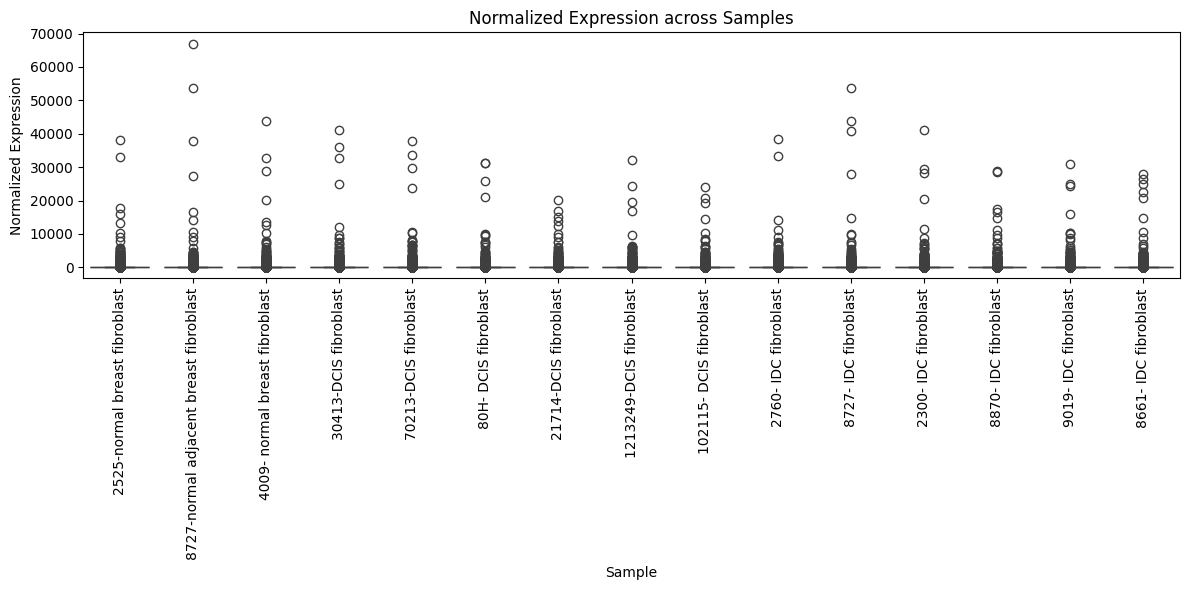

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(12, 6))
sns.boxplot(x="Sample", y="Normalized Expression", data=norm_counts_melted)
plt.xticks(rotation=90)
plt.title("Normalized Expression across Samples")
plt.tight_layout()
plt.show()



In [237]:
print(metadata.columns)


Index(['Condition'], dtype='object')


In [238]:
metadata = metadata.rename(columns={"Sample_ID": "Sample"})


In [152]:
print(metadata.index)


Index(['Gene_Name', '2525-normal breast fibroblast',
       '8727-normal adjacent breast fibroblast',
       '4009- normal breast fibroblast', '30413-DCIS fibroblast',
       '70213-DCIS fibroblast', '80H- DCIS fibroblast',
       '21714-DCIS fibroblast', '1213249-DCIS fibroblast',
       '102115- DCIS fibroblast', '2760- IDC fibroblast',
       '8727- IDC fibroblast', '2300- IDC fibroblast', '8870- IDC fibroblast',
       '9019- IDC fibroblast', '8661- IDC fibroblast'],
      dtype='object')


In [240]:
print(metadata.head())  # This will show the first few rows of metadata for inspection


  Condition
0    normal
1    normal
2    normal
3    normal
4      DCIS


In [241]:
# Create the 'Sample' column in metadata based on its index (assuming each row corresponds to a sample)
metadata['Sample'] = metadata.index.astype(str)

# Print to check if it has worked correctly
print(metadata.head())  # Verify if 'Sample' column is now added


  Condition Sample
0    normal      0
1    normal      1
2    normal      2
3    normal      3
4      DCIS      4


In [242]:
# Assuming df is your normalized counts DataFrame
norm_counts_melted = df.melt(id_vars=['Gene_ID', 'Gene_Name'], var_name="Sample", value_name="Normalized Expression")

# Print to check if 'Sample' column is created correctly in norm_counts_melted
print(norm_counts_melted.head())  # Verify if 'Sample' column exists


  Gene_ID     Gene_Name                         Sample  Normalized Expression
0       0  32135.564190  2525-normal breast fibroblast           32927.997990
1   42796     20.505090  2525-normal breast fibroblast              19.419049
2   42797      6.912624  2525-normal breast fibroblast               3.553181
3   42798     51.940829  2525-normal breast fibroblast             129.149021
4   42799     29.968198  2525-normal breast fibroblast              31.849817


In [243]:
# Merge with metadata to get 'Condition'
norm_counts_melted = norm_counts_melted.merge(metadata[["Sample", "Condition"]], on="Sample", how="left")

# Check for issues
print("\nMissing Values:\n", norm_counts_melted.isna().sum())
print("\nUnique Conditions:\n", norm_counts_melted["Condition"].unique())
print("\nExpression Stats:\n", norm_counts_melted["Normalized Expression"].describe())

# Drop NaN values if any
norm_counts_melted = norm_counts_melted.dropna()



Missing Values:
 Gene_ID                       0
Gene_Name                     0
Sample                        0
Normalized Expression         0
Condition                160035
dtype: int64

Unique Conditions:
 [nan]

Expression Stats:
 count    160035.000000
mean         89.863700
std         664.402837
min           0.000000
25%          12.044645
50%          27.103360
75%          60.940819
max       67028.115680
Name: Normalized Expression, dtype: float64


In [245]:
# Ensure metadata has the 'Sample' column based on its index
metadata['Sample'] = metadata.index.astype(str)

# Print to verify that the 'Sample' column is added correctly
print(metadata.head())  # Now the metadata should have a 'Sample' column for matching



  Condition Sample
0    normal      0
1    normal      1
2    normal      2
3    normal      3
4      DCIS      4


In [249]:
# Reset the index to move 'Gene_ID' and 'Gene_Name' as columns
norm_counts_df_reset = norm_counts_df.reset_index()

# Now proceed to reshape the DataFrame
norm_counts_melted = norm_counts_df_reset.melt(id_vars=['Gene_ID', 'Gene_Name'], var_name="Sample", value_name="Normalized Expression")

# Print to verify if the reshaped DataFrame has the 'Sample' column
print(norm_counts_melted.head())  # Verify the reshaped DataFrame


  Gene_ID     Gene_Name                         Sample  Normalized Expression
0       0  32135.564190  2525-normal breast fibroblast           32927.997990
1   42796     20.505090  2525-normal breast fibroblast              19.419049
2   42797      6.912624  2525-normal breast fibroblast               3.553181
3   42798     51.940829  2525-normal breast fibroblast             129.149021
4   42799     29.968198  2525-normal breast fibroblast              31.849817


In [253]:
print(norm_counts_df.columns)

Index(['Gene_Name', '2525-normal breast fibroblast',
       '8727-normal adjacent breast fibroblast',
       '4009- normal breast fibroblast', '30413-DCIS fibroblast',
       '70213-DCIS fibroblast', '80H- DCIS fibroblast',
       '21714-DCIS fibroblast', '1213249-DCIS fibroblast',
       '102115- DCIS fibroblast', '2760- IDC fibroblast',
       '8727- IDC fibroblast', '2300- IDC fibroblast', '8870- IDC fibroblast',
       '9019- IDC fibroblast', '8661- IDC fibroblast'],
      dtype='object')


In [254]:
print(norm_counts_melted.dtypes)

Gene_ID                   object
Gene_Name                float64
Sample                    object
Normalized Expression    float64
Condition                 object
dtype: object


In [255]:
print(norm_counts_melted.groupby("Condition")["Normalized Expression"].describe())


Empty DataFrame
Columns: [count, mean, std, min, 25%, 50%, 75%, max]
Index: []


In [256]:
print(norm_counts_melted["Condition"].value_counts())

Series([], Name: count, dtype: int64)


In [267]:
pip install kaleido

In [262]:
!pip install -U kaleido


In [273]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_cd['-log10(padj)'] = -np.log10(results_cd['padj'])  # Convert p-value scale
results_cd['Significance'] = np.where(
    (results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_cd,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()
fig.write_html("volcano_cd.html")


<ipython-input-273-80f9acccf7d7>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-273-80f9acccf7d7>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [274]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_cd['-log10(padj)'] = -np.log10(results_cd['padj'])  # Convert p-value scale
results_cd['Significance'] = np.where(
    (results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_cd,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()
fig.write_html("volcano_ci.html")


<ipython-input-274-73d2ef359bc0>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-274-73d2ef359bc0>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [275]:
import plotly.express as px
import pandas as pd
import numpy as np

# Define threshold values
log2fc_threshold = 0.5  # Minimum fold-change threshold
pval_threshold = 0.05   # Significance threshold

# Prepare data
results_cd['-log10(padj)'] = -np.log10(results_cd['padj'])  # Convert p-value scale
results_cd['Significance'] = np.where(
    (results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] > log2fc_threshold), 'Upregulated',
    np.where((results_cd['padj'] < pval_threshold) & (results_cd['log2FoldChange'] < -log2fc_threshold), 'Downregulated',
             'Not Significant')
)

# Create interactive volcano plot
fig = px.scatter(results_cd,
                 x="log2FoldChange",
                 y="-log10(padj)",
                 color="Significance",
                 hover_name=results_cd.index,  # Gene names
                 title="Volcano Plot of Differentially Expressed Genes",
                 labels={"log2FoldChange": "Log2 Fold Change", "-log10(padj)": "-Log10 Adjusted P-Value"},
                 color_discrete_map={"Upregulated": "red", "Downregulated": "blue", "Not Significant": "grey"}
                )

# Add significance threshold lines
fig.add_hline(y=-np.log10(pval_threshold), line_dash="dash", line_color="black")
fig.add_vline(x=log2fc_threshold, line_dash="dash", line_color="black")
fig.add_vline(x=-log2fc_threshold, line_dash="dash", line_color="black")

# **Adjust figure size**
fig.update_layout(
    autosize=True,
    width=1000,  # Width can be adjusted as needed
    height=800,  # Increased height for better visibility
    font=dict(size=14)  # Adjust font size for readability
)

# Show interactive plot
fig.show()
fig.write_html("volcano_di.html")


<ipython-input-275-d3226adb9eb4>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-275-d3226adb9eb4>:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [278]:
# Filter significant DEGs
significant_genes = results_cd[
    (results_cd['padj'] < 0.05) &
    (abs(results_cd['log2FoldChange']) > 0.5)
]

# Save gene symbols to a text file
significant_genes.index.to_series().to_csv("DEG_gene_list.txt", index=False, header=False)
